### BrainBERT for SEED dataset
##### BrainBERT on raw SEED data (9_1.cnt): Considering computer memory limitations, only a part of the original data was selected for processing. The first 16 channels + first 300 seconds. (regarding the seed introduction file, 24->264: label=1； 289->526: label=0)
##### Full pipeline: read CNT -> window -> resample to 2048 -> STFT -> BrainBERT (using the pretrained weight: stft_large_pretrained.pth) -> save embeddings and visulization embeddings

In [20]:
import os
import sys
from pathlib import Path

import numpy as np
import torch
import mne
from omegaconf import OmegaConf
from scipy import signal, stats

In [21]:
root = None
for p in [Path.cwd()] + list(Path.cwd().parents):
    if (p / "pretrained_weights").exists() and (p / "data").exists():
        root = p
        break
print("Project root:", root)

CNT_PATH  = root / "data" / "seed_eeg" / "9_1.cnt"
CKPT_PATH = root / "pretrained_weights" / "stft_large_pretrained.pth"
OUT_DIR   = root / "notebooks" / "02_brainbert_seed" / "brainbert_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
print("CNT:", CNT_PATH)
print("CKPT:", CKPT_PATH)
print("OUT:", OUT_DIR)

Project root: f:\TUD\Phd_application\Oulu\Code
device: cuda
CNT: f:\TUD\Phd_application\Oulu\Code\data\seed_eeg\9_1.cnt
CKPT: f:\TUD\Phd_application\Oulu\Code\pretrained_weights\stft_large_pretrained.pth
OUT: f:\TUD\Phd_application\Oulu\Code\notebooks\02_brainbert_seed\brainbert_outputs


### Import BrainBERT repo

In [22]:
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import models  # BrainBERT official models package

In [30]:
def safe_zscore(x, axis=-1, eps=1e-6):
    mean = np.mean(x, axis=axis, keepdims=True)
    std  = np.std(x, axis=axis, keepdims=True)
    std = np.where(std < eps, 1.0, std)
    return (x - mean) / std

def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5

    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = safe_zscore(Zxx, axis=-1) 
        t = t[clip:-clip]
    elif normalizing == "baselined":
        raise NotImplementedError("baseline() not provided.")
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip] + 1e-8)
        t = t[clip:-clip]

    Zxx = np.nan_to_num(Zxx, nan=0.0, posinf=0.0, neginf=0.0)

    return f, t, Zxx

In [25]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path, map_location="cpu")
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream, init_state

def load_model_weights(model, states, multi_gpu=False):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

cfg = OmegaConf.create({"upstream_ckpt": str(CKPT_PATH)})
model, init_state = build_model(cfg)
model.to(device)
load_model_weights(model, init_state["model"], multi_gpu=False)
model.eval()
print("Model loaded.")

d:\Anaconda3\envs\brainbert\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model loaded.


### Load SEED data (first 16 channels and top 300s)

In [27]:
raw = mne.io.read_raw_cnt(str(CNT_PATH), preload=False, verbose="ERROR")
picks = mne.pick_types(raw.info, eeg=True, eog=False, emg=False, stim=False, exclude=[])
raw.pick(picks)

# first 16 channels
raw.pick_channels(raw.ch_names[:16])

sfreq = float(raw.info["sfreq"])
print(raw)
print("sfreq:", sfreq)
print("channels:", len(raw.ch_names))
print("ch_names:", raw.ch_names)

T_MAX_SEC   = 300.0
WIN_SEC     = 4.0
STRIDE_SEC  = 1.0

start_sample = 0
stop_sample  = int(T_MAX_SEC * sfreq)

win    = int(WIN_SEC * sfreq)
stride = int(STRIDE_SEC * sfreq)

starts = np.arange(start_sample, stop_sample - win + 1, stride)
print("Will process windows:", len(starts), " (expected ~297 if win=4s stride=1s)")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<RawCNT | 9_1.cnt, 16 x 7638960 (7639.0 s), ~49 kB, data not loaded>
sfreq: 1000.0
channels: 16
ch_names: ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5']
Will process windows: 297  (expected ~297 if win=4s stride=1s)


C:\Users\Yin Hang\AppData\Local\Temp\ipykernel_27548\1478010722.py:1: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(str(CNT_PATH), preload=False, verbose="ERROR")
C:\Users\Yin Hang\AppData\Local\Temp\ipykernel_27548\1478010722.py:1: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(str(CNT_PATH), preload=False, verbose="ERROR")


In [32]:
def resample_to_2048(wav_1d, in_sfreq):
    """Resample 1D signal from in_sfreq to 2048Hz using polyphase."""
    in_sfreq = int(round(in_sfreq))
    if in_sfreq == 2048:
        return wav_1d.astype(np.float32)
    return signal.resample_poly(wav_1d, up=2048, down=in_sfreq).astype(np.float32)

@torch.no_grad()
def brainbert_embed_one_channel(model, wav_2048, device):
    # STFT params identical to official example
    f, t, linear = get_stft(
        wav_2048,
        2048,
        clip_fs=40,
        nperseg=400,
        noverlap=350,
        normalizing="zscore",
        return_onesided=True
    )  # linear: (F=40, Tspec)

    inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to(device)  # (1, Tspec, 40)
    mask = torch.zeros(inputs.shape[:2], dtype=torch.bool, device=device)       # (1, Tspec)

    out = model.forward(inputs, mask, intermediate_rep=True)  # (1, Tspec, D)
    feat = out[0].mean(dim=0)                                 # (D,) time-mean pooling
    return feat.detach().cpu().numpy()

### Main code

In [33]:
all_embeddings = []

for wi, s in enumerate(starts):
    seg = raw.get_data(start=int(s), stop=int(s + win))
    seg = (seg * 1e6).astype(np.float32)

    ch_feats = []
    for c in range(seg.shape[0]):
        wav_2048 = resample_to_2048(seg[c], sfreq)
        feat = brainbert_embed_one_channel(model, wav_2048, device)
        ch_feats.append(feat)

    ch_feats = np.stack(ch_feats, axis=0) 
    win_feat = ch_feats.mean(axis=0)
    all_embeddings.append(win_feat)

    if (wi + 1) % 10 == 0:
        print(f"processed {wi+1}/{len(starts)} windows")

emb = np.stack(all_embeddings, axis=0)  # (N_windows, D)
print("Final embedding shape:", emb.shape)

processed 10/297 windows
processed 20/297 windows
processed 30/297 windows
processed 40/297 windows
processed 50/297 windows
processed 60/297 windows
processed 70/297 windows
processed 80/297 windows
processed 90/297 windows
processed 100/297 windows
processed 110/297 windows
processed 120/297 windows
processed 130/297 windows
processed 140/297 windows
processed 150/297 windows
processed 160/297 windows
processed 170/297 windows
processed 180/297 windows
processed 190/297 windows
processed 200/297 windows
processed 210/297 windows
processed 220/297 windows
processed 230/297 windows
processed 240/297 windows
processed 250/297 windows
processed 260/297 windows
processed 270/297 windows
processed 280/297 windows
processed 290/297 windows
Final embedding shape: (297, 768)


### Save embeddings

In [34]:
out_path = OUT_DIR / f"{CNT_PATH.stem}_ch16_first300s_win{WIN_SEC:g}s_stride{STRIDE_SEC:g}s_emb.npz"
np.savez_compressed(
    out_path,
    emb=emb,
    starts=starts,
    sfreq=sfreq,
    ch_names=np.array(raw.ch_names, dtype=object),
    win_sec=WIN_SEC,
    stride_sec=STRIDE_SEC,
    t_max_sec=T_MAX_SEC,
)
print("Saved:", out_path)

Saved: f:\TUD\Phd_application\Oulu\Code\notebooks\02_brainbert_seed\brainbert_outputs\9_1_ch16_first300s_win4s_stride1s_emb.npz


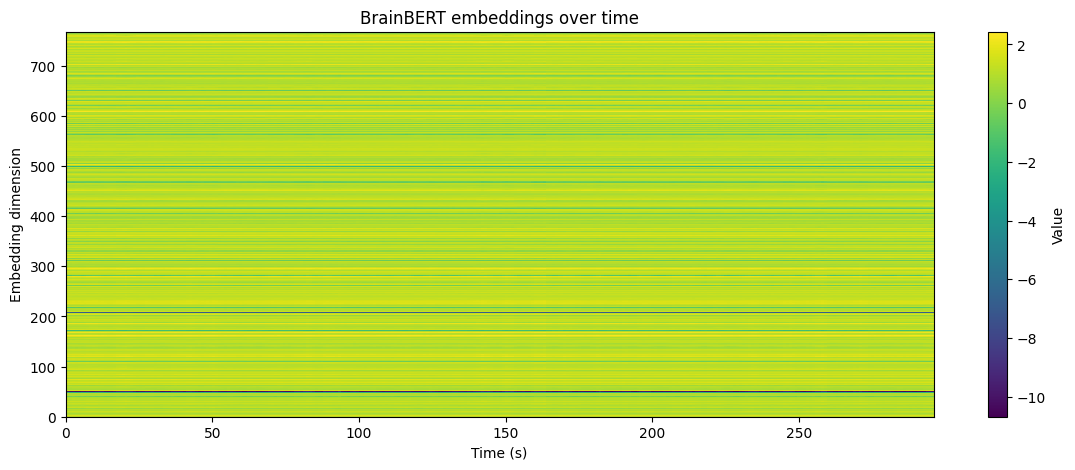

In [36]:
import matplotlib.pyplot as plt
import numpy as np

times_sec = starts / sfreq

plt.figure(figsize=(14, 5))
plt.imshow(emb.T, aspect="auto", interpolation="nearest",
           extent=[times_sec.min(), times_sec.max(), 0, emb.shape[1]])
plt.colorbar(label="Value")
plt.xlabel("Time (s)")
plt.ylabel("Embedding dimension")
plt.title("BrainBERT embeddings over time")
plt.show()